<a href="https://colab.research.google.com/github/josephassiga/tensorflow-and-keras-tutorial/blob/main/W3/Lab5/W3_Lab_1_intro_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP)

NLP is about: using machine learning and large datasets to
give computers the ability not to understand language, which is a more lofty goal, but to ingest a piece of language as input and return something useful, like predicting the following:

*  What’s the topic of this text?: text classification.
*  Does this text contain abuse?: content filtering.
*  Does this text sound positive or negative?: sentiment analysis.
*  What should be the next word in this incomplete sentence?: language modeling
*  How would you say this in German?: translation.
*  How would you summarize this article in one paragraph?” : summarization.





# Preparing text data

Deep learning models, being differentiable functions, can only process numeric tensors: they can’t take raw text as input. Vectorizing text is the process of transforming text into numeric tensors :

* First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
* You split the text into units (called tokens), such as characters, words, or groups of words. This is called tokenization.
* You convert each such token into a numerical vector. This will usually involve
first indexing all tokens present in the data.

Let's review each of these steps:

![From raw text to vectors](https://github.com/josephassiga/tensorflow-and-keras-tutorial/blob/main/W3/Lab5/images/text-vectorization.png?raw=1)

# Text Standardization:

    One of the simplest and most widespread standardization schemes are:
    * Convert to lowercase and remove punctuation characters.
    * Convert special characters to a standars form : replacing “é” with “e,” “æ” with “ae,” and so on.

 # Text Spliting :

    Once your text is standardized, you need to break it up into units to be vectorized(tokens), a step called tokenization. You could do this in three different ways:
    * Word-level tokenization—Where tokens are space-separated (or punctuationseparated) substrings.
    * N-gram tokenization—Where tokens are groups of N consecutive words.
    * Character-level tokenization—Where each character is its own token
  In general, you’ll always use either **word-level** or **N-gram** tokenization


In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

# Preparing the IMDB movie review data

In [32]:
! rm -Rf aclImdb
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
! rm -r aclImdb/train/unsup/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.4M      0  0:00:04  0:00:04 --:--:-- 19.3M


In [30]:
! cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [33]:
# Prepare the validation set by setting apart 20% of the training text files in a new directory :

import os, pathlib, shutil, random

base_dir = os.path.join("aclImdb")
val_dir = os.path.join(base_dir, "val")
train_dir = os.path.join(base_dir, "train")

for category in ['neg', 'pos']:
  dst_dir = os.path.join(val_dir, category)
  src_dir = os.path.join(train_dir, category)
  os.makedirs(dst_dir)
  files = os.listdir(src_dir)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for filename in val_files:
    file_src = os.path.join(src_dir, filename)
    file_dst = os.path.join(dst_dir,filename)
    shutil.move(file_src,file_dst)


In [34]:
batch_size = 32
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/train", batch_size=batch_size
)

val_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/val", batch_size=batch_size
)

test_ds = keras.utils.text_dataset_from_directory(
 "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


# Preprocessing our dataset :

In [35]:
# Encode the output tokens as multi-hot binary vectors.
text_vectorization = TextVectorization(
 max_tokens=20000,
 output_mode="multi_hot",
)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

binary_1gram_val_ds = val_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

binary_1gram_test_ds = test_ds.map(
 lambda x, y: (text_vectorization(x), y),
 num_parallel_calls=4)

# Create the model

In [36]:
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
    return model

def get_model_sequential(max_tokens=20000, hidden_dim=16):
   model =  keras.Sequential([
        keras.layers.Dense(hidden_dim, activation="relu", input_shape=(max_tokens,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid")
    ])

   model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
   return model


Now inspecting the data of the Jena weather dataset

1 Training and testing the binary unigram model

In [38]:
model = get_model()
model.summary()

callbacks = [
 keras.callbacks.ModelCheckpoint("binary_1gram.keras",
 save_best_only=True)
]

history = model.fit(binary_1gram_train_ds.cache(),
validation_data=binary_1gram_val_ds.cache(),
 epochs=10,
 callbacks=callbacks)

model = keras.models.load_model("binary_1gram.keras")

print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 13ms/step - loss: 0.4120 - accuracy: 0.8278 - val_loss: 0.2798 - val_accuracy: 0.8900
Epoch 2/10
6

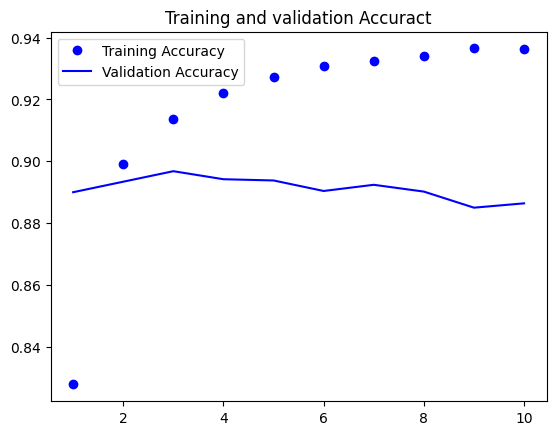

In [39]:
import matplotlib.pyplot as plt
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuract")
plt.legend()
plt.show()